In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, optimize
from scipy.optimize import curve_fit
import control as ctrl

### Funciones a utilizar

In [3]:
def graficar_t(tiempo, senial_t, titulo, color = None):
    """
    Funcion que grafica una señal en funcion del tiempo.
    Entradas:
             tiempo: vector del eje del tiempo
             senial_t: vector que contiene la señal a graficar
             titulo: titulo de la grafica
    Salidas:
             Grafica la señal en funcion del tiempo.
    """
    if color is None: color = "b"
    else: color = color
    plt.plot(tiempo, senial_t, color, label = titulo)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.legend()

### Obtencion de Datos

In [4]:
ruta_excel = 'EnsayoCaja.xlsx'
print(f"Ruta Especificada: {ruta_excel}")
df = pd.read_excel(ruta_excel)
print(df.head(300))    #devuelve las n primeras filas

#/home/joel/Documents/Repositorios/controlador-PID/EnsayoCaja.xlsx

Ruta Especificada: EnsayoCaja.xlsx
     Temperatura[ºC]  Tension[V]  Tiempo [Seg]  Temp. Ambiente[ºC]
0               22.5    3.764706             0                22.0
1               22.7    3.764706             1                 NaN
2               23.1    3.764706             2                 NaN
3               22.7    3.764706             3                 NaN
4               22.8    3.764706             4                 NaN
..               ...         ...           ...                 ...
295             47.8    0.000000           295                 NaN
296             47.7    0.000000           296                 NaN
297             47.8    0.000000           297                 NaN
298             47.0    0.000000           298                 NaN
299             47.1    0.000000           299                 NaN

[300 rows x 4 columns]


In [5]:
# Obtengamos los parametros.
temp = df.iloc[:, 0].to_numpy()
entrada = df.iloc[:, 1].to_numpy()
t = df.iloc[:, 2].to_numpy()
temp_amb = df.iloc[0, 3]

# iloc toma filas y columnas
# to_numpy transforma en un array

temp = temp - temp_amb                  # Correcion de Condiciones Iniciales Nulas

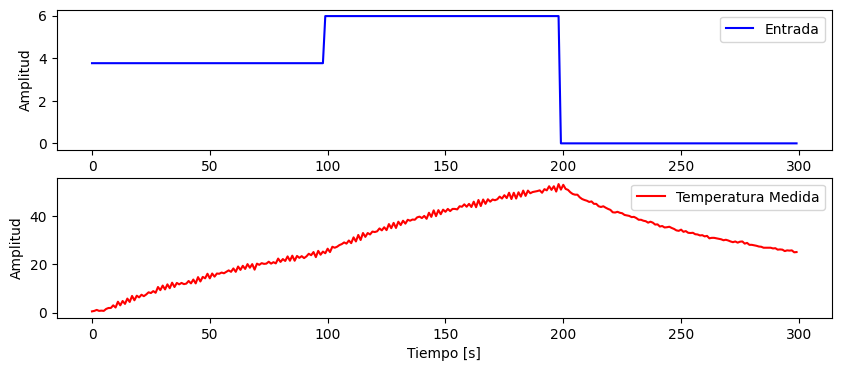

In [6]:
plt.figure(figsize=(10,4))
plt.subplot(211)
graficar_t(t, entrada, "Entrada", 'b')
plt.subplot(212)
graficar_t(t, temp, "Temperatura Medida", 'r')
plt.show()

#subplot(xyz): 'x' identifica la cantidad filas, 'y' la posicion en columna, y 'z' la posicion en fila

### Modelado - Punto2

In [7]:
print(entrada[-1])
entrada = np.where(entrada == 0, 0.001, entrada)
print(entrada[-1])

#creo que lo único que hace es ajustar el cero, seguramente para la grafica

0.0
0.001


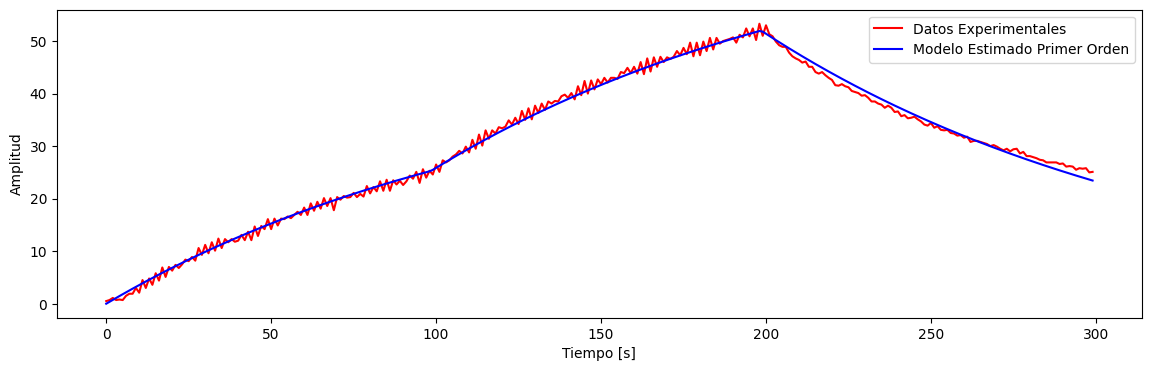

Parámetros optimizados:
 K = 12.3959016600887,
 tau = 126.14063383086838
Errores: [0.03873352 0.80437641]


In [8]:
# Función de transferencia de primer orden (pide comportamiento sobreamortiguado)
def modelo_primer_orden(t, K, tau):
    sistema = signal.lti([K], [tau, 1])
    _, y, _ = signal.lsim(sistema, entrada, t) #Tout,Yout,Xout. Sirve para graficar el resultado del filtro (o modelo)
    return y

# Ajustar el modelo de primer orden a los datos experimentales
params_iniciales = [1.0, 1.0]                   # Puedes ajustar esto según tu conocimiento del sistema
params_optimizados, covariance = curve_fit(modelo_primer_orden, t, temp, p0=params_iniciales) # aproximacion por minimos cuadrados

K_optimizado, tau_optimizado = params_optimizados

# Simular la respuesta del sistema con el modelo optimizado
sistema_optimizado = signal.lti([K_optimizado], [tau_optimizado, 1])
t_simulado, y_simulado, _ = signal.lsim(sistema_optimizado, entrada, t)

# Graficar los resultados
plt.figure(figsize=(14,4))
graficar_t(t,temp,"Datos Experimentales", 'r')
graficar_t(t_simulado, y_simulado, "Modelo Estimado Primer Orden", 'b')
plt.show()

# Mostrar los parámetros optimizados
errores1 = np.sqrt(np.diag(covariance))
print(f'Parámetros optimizados:\n K = {K_optimizado},\n tau = {tau_optimizado}')
print(f"Errores: {errores1}")

Función de transferencia: [0.09827049] / [1.         0.00792766]


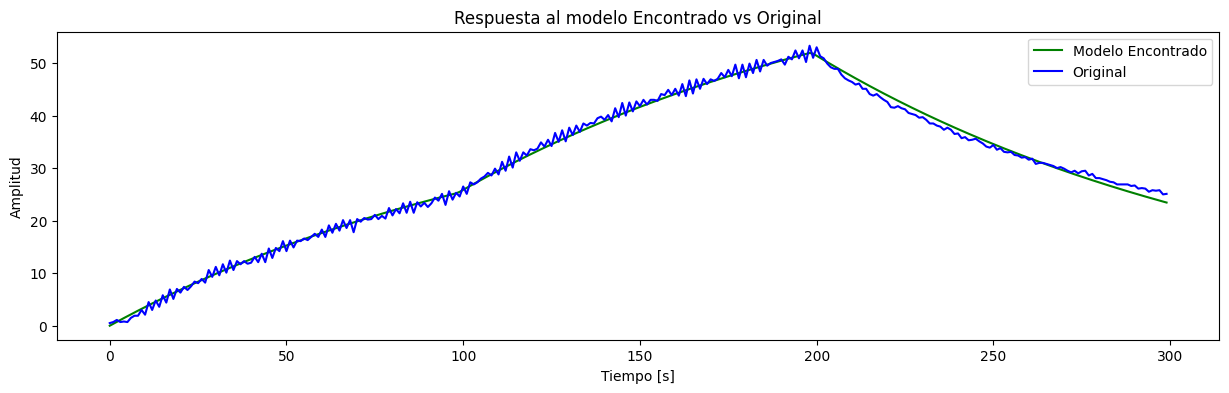

In [9]:
# Crear la función de transferencia con los valores optimizados
system = signal.TransferFunction([K_optimizado],[tau_optimizado, 1])
print(f'Función de transferencia: {system.num} / {system.den}')
# Simular la respuesta del sistema a la señal senoidal
t_out, respuesta, _ = signal.lsim(system, U=entrada, T=t)

plt.figure(figsize=(15,4))
plt.title("Respuesta al modelo Encontrado vs Original")
graficar_t(t_out,respuesta,"Modelo Encontrado",'g')
graficar_t(t,temp,"Original",'b')
plt.show()


Función de transferencia: (array([[0.04894125, 0.04894125]]), array([ 1.        , -0.99210364]), 1)


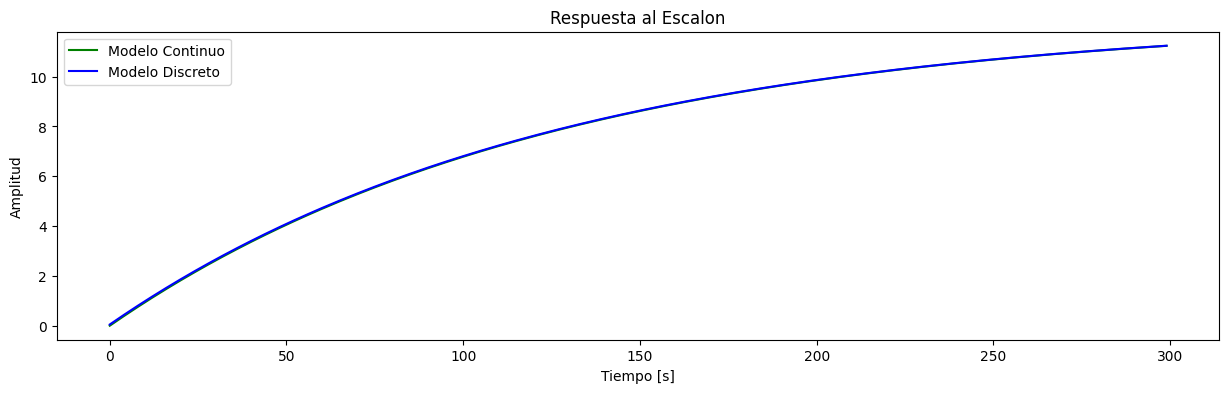

In [10]:
t_escalon, respuesta_escalon = signal.step(system, T=t)
# Discreto
Ts = 1              # Indicado en el TP
system_discreto = signal.cont2discrete((system.num,system.den), Ts, method='bilinear')
print(f'Función de transferencia: {system_discreto}')
t_discreto, respuesta_discreto = signal.dstep(system_discreto, t=t_escalon)


# Grafiquemos
plt.figure(figsize=(15,4))
plt.title("Respuesta al Escalon")
graficar_t(t_escalon,respuesta_escalon,"Modelo Continuo",'g')
graficar_t(t_discreto, respuesta_discreto[0],"Modelo Discreto",'b')
#plt.axis([0,10,0,2])
plt.show()

### Aplicar un controlador PI - Punto3

Funcion de Transferencia de la Planta: 
  0.09827
------------
s + 0.007928

Controlador PI: 
221 s + 1.7
-----------
   130 s

Funcion de Transferencia del Sistema Realimentado: 
     21.72 s + 0.1671
--------------------------
130 s^2 + 22.75 s + 0.1671

Tiempo de establecimiento al 2%: 23.35 [s].
Valor estacionario: 0.998


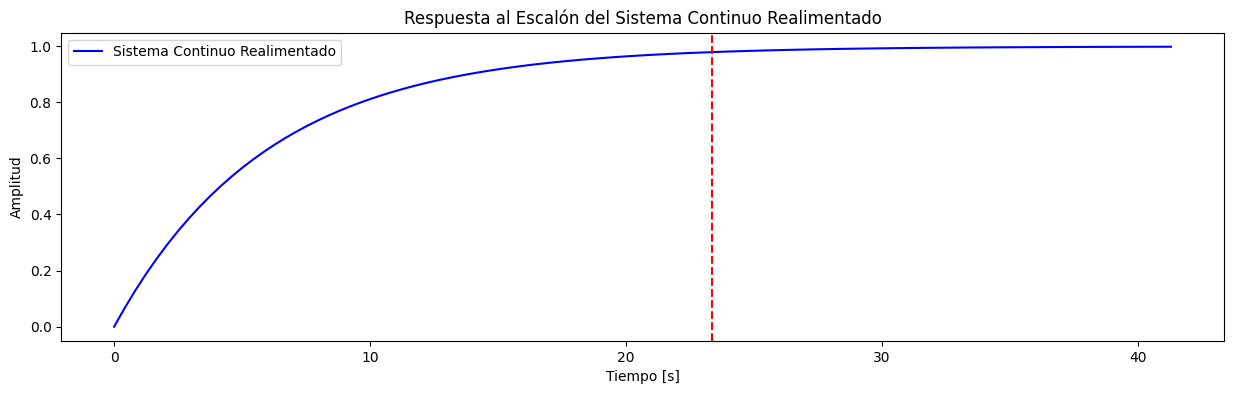

In [11]:
# Ahora utilizamos la libreria ctrl
planta = ctrl.tf(system.num, system.den)
print(f"Funcion de Transferencia de la Planta: {planta}")


KP = 1.7 # creo que asigna este valor. No entiendo por qué. Con este valor t_establecimiento < 25s
Ti = 130 # esto tampoco entiendo. Cambia el valor de estado estacionario

cont_P = ctrl.tf([KP],[1])
cont_I = ctrl.tf([KP],[Ti , 0])
controlador_PI = ctrl.parallel(cont_P,cont_I)
print(f"Controlador PI: {controlador_PI}")

# Realimentación del sistema con el controlador PI utilizando ctrl.feedback
camino_directo = ctrl.series(planta,controlador_PI)
sistema_realimentado = ctrl.feedback(camino_directo,1)
print(f"Funcion de Transferencia del Sistema Realimentado: {sistema_realimentado}")
step_sistema_realimentado = ctrl.step_response(sistema_realimentado) #respuesta al escalon, para tiempo de establecimiento


# Verifiquemos que el tiempo de establecimiento sea menor a 25 seg
valor_estacionario = step_sistema_realimentado.outputs[-1] # ultimo valor
banda = 0.02 * valor_estacionario #margen del 2%
indices_banda = np.where(np.abs(step_sistema_realimentado.outputs - valor_estacionario) < banda)[0]
tiempo_establecimiento = step_sistema_realimentado.time[indices_banda[0]]
print(f"Tiempo de establecimiento al 2%: {round(tiempo_establecimiento,2)} [s].") #redondear a 2 decimales
print(f"Valor estacionario: {round(valor_estacionario,3)}")                                                                                                                              


# Graficar la respuesta al escalón del sistema continuo realimentado
plt.figure(figsize=(15, 4))
plt.title("Respuesta al Escalón del Sistema Continuo Realimentado")
graficar_t(step_sistema_realimentado.time, step_sistema_realimentado.outputs, "Sistema Continuo Realimentado", 'b')
plt.axvline(x=tiempo_establecimiento, color='red', linestyle='--')
plt.show()

### PUNTO4 - Saturacion . No entiendo, y no funciona

Funcion de Transferencia del Sistema Realimentado: [ 0.16707692  0.         12.85384615]/[1.         0.175      0.00128538]


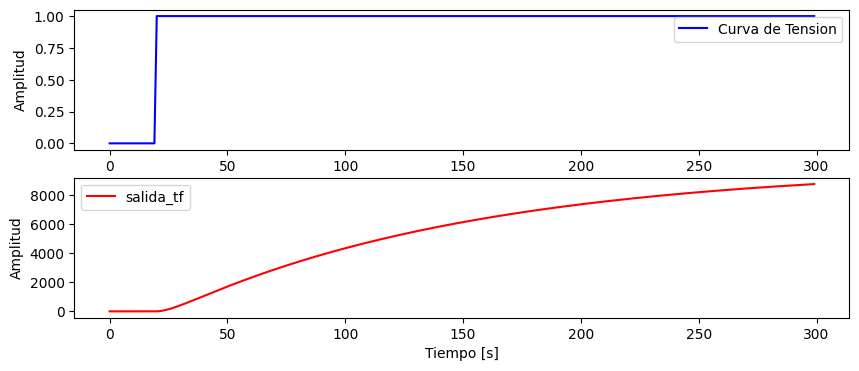

In [16]:
#Ahora cuento con una ft, que me permite estudiar como responde el sistema a sus variaciones de tension...
#Uso la funcion transferencia del sistema realimentado:
from telnetlib import theNULL


sistema_realimentado_tf = signal.TransferFunction([21.72, 0,1671],[130, 22.75, 0.1671])
print(f"Funcion de Transferencia del Sistema Realimentado: {sistema_realimentado_tf.num}/{sistema_realimentado_tf.den}")

# genero la señal de alimentación
tension_minima = 0
tension_maxima = 12
tension_inicial = 1
cantidad_de_muestras = 300
persistencia = 20
muestras_en_saturacion = 0

curva_de_tension = np.zeros(cantidad_de_muestras)
for i in range (0, int(cantidad_de_muestras/persistencia)):
    for j in range (i*persistencia,(1+i)*persistencia):
        if i<=tension_inicial: curva_de_tension[j] = tension_minima + i
        else: 
            curva_de_tension[j]=tension_inicial
            muestras_en_saturacion += 1

plt.figure(figsize=(10,4))
plt.subplot(211)
graficar_t(t, curva_de_tension,"Curva de Tension", 'b')
#print(f"Muestras en saturacion: {muestras_en_saturacion} \n")
#print(f"Curva de alimentacion: \n{curva_de_tension} ")
plt.subplot(212)
t_curva, respuesta_curva,_ = signal.lsim(sistema_realimentado_tf,U=curva_de_tension,T=t)
graficar_t(t_curva, respuesta_curva,"salida_tf", 'r')




### Modelo Segundo Orden - No funciona

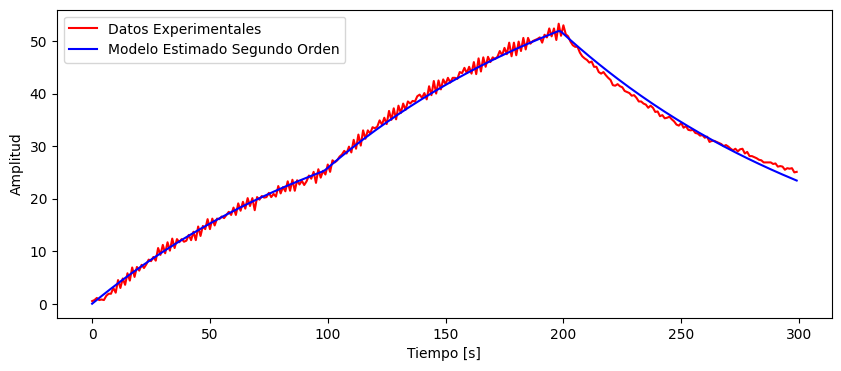

Parámetros optimizados:
 K = 12.3959016600887, 
 zeta = 1004.7692426670638, 
 omega = 15.930957177776438
Errores estándar de los parámetros del modelo de segundo orden: [23315034.56747755  3715434.08874398    59154.28482235]


In [13]:
def modelo_segundo_orden(t, K, zeta, omega_n):
    sistema = signal.lti([K], [1, 2 * zeta * omega_n, omega_n**2])
    _, y, _ = signal.lsim(sistema, entrada, t)
    return y

# Ajustar el modelo de segundo orden a los datos experimentales
params_iniciales_2do_orden = [13, 0.1, 5]  # Puedes ajustar esto según tu conocimiento del sistema
params_optimizados_2do_orden, covariance_2do_orden = curve_fit(modelo_segundo_orden, t, temp, p0=params_iniciales_2do_orden)

K_optimizado_2do_orden, zeta_optimizado_2do_orden, omega_n_optimizado_2do_orden = params_optimizados_2do_orden

# Simular la respuesta del sistema con el modelo optimizado de segundo orden
sistema_optimizado_2do_orden = signal.lti([K_optimizado_2do_orden], [1, 2 * zeta_optimizado_2do_orden * omega_n_optimizado_2do_orden, omega_n_optimizado_2do_orden**2])
t_simulado_2do_orden, y_simulado_2do_orden, _ = signal.lsim(sistema_optimizado_2do_orden, entrada, t)

# Graficar los resultados del modelo de segundo orden
plt.figure(figsize=(10,4))
graficar_t(t,temp,"Datos Experimentales", 'r')
graficar_t(t_simulado_2do_orden, y_simulado_2do_orden, "Modelo Estimado Segundo Orden", 'b')
plt.show()

# Mostrar los parámetros optimizados del modelo de segundo orden
errores_estandar_2do_orden = np.sqrt(np.diag(covariance_2do_orden))
print(f'Parámetros optimizados:')
print(f' K = {K_optimizado}, \n zeta = {zeta_optimizado_2do_orden}, \n omega = {omega_n_optimizado_2do_orden}')
print(f'Errores estándar de los parámetros del modelo de segundo orden: {errores_estandar_2do_orden}')
